## Setting up:

In [2]:
import pandas as pd
#import os
import warnings
import massbalancemachine as mbm
#from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
#import geopandas as gpd
#import salem
#import logging
#import re
import numpy as np
#from os.path import isfile, join, isdir
#from tqdm import tqdm
#from oggm import utils, workflow, tasks
from oggm import cfg as oggmCfg
from cmcrameri import cm

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.config_NOR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig()

oggmCfg.initialize(logging_level='WARNING')
oggmCfg.PARAMS['border'] = 10
oggmCfg.PARAMS['use_multiprocessing'] = True
oggmCfg.PARAMS['continue_on_error'] = True
# Module logger
#log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-06-02 14:45:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-02 14:45:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-02 14:45:40: oggm.cfg: Multiprocessing: using all available processors (N=12)
2025-06-02 14:45:40: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-06-02 14:45:40: oggm.cfg: Multiprocessing switched ON after user settings.
2025-06-02 14:45:40: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [3]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load stakes, split into winter and annual rows, fill missing dates of certain stake measurement sequences from NaN to hydr. year date

In [4]:
df_stakes = pd.read_csv(path_PMB_WGMS_raw + '/glaciological_point_mass_balance_Norway.csv')

df_stakes = df_stakes.rename(columns={'rgiid': 'RGIId'})

df_stakes_filled = fill_missing_dates(df_stakes)
df_stakes_split = split_stake_measurements(df_stakes_filled)

display(df_stakes_split)


Filling 226 missing previous year dates...


,RGIId,breid,altitude,lat,lon,approx_loc,approx_altitude,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
0,RGI60-08.01258,54,471,70.12589,21.77702,N,N,25.09.2012,07.11.2013,-4.92,annual,2013
1,RGI60-08.01258,54,439,70.12578,21.77630,N,N,07.11.2013,24.09.2014,-2.67,annual,2014
2,RGI60-08.01258,54,444,70.12573,21.77590,N,N,24.09.2014,23.09.2015,-3.41,annual,2015
3,RGI60-08.01258,54,444,70.12573,21.77590,N,N,23.09.2015,22.09.2016,-3.59,annual,2016
4,RGI60-08.01258,54,468,70.12554,21.77352,N,N,22.09.2016,29.09.2017,-2.46,annual,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
7656,RGI60-08.02969,3141,1078,59.93803,6.34733,N,N,01.10.2012,03.05.2012,1.50,winter,2012
7657,RGI60-08.02969,3141,1078,59.93789,6.34729,N,N,12.10.2012,29.05.2013,1.14,winter,2013
7658,RGI60-08.02969,3141,1079,59.93815,6.34702,N,N,14.10.2014,22.04.2015,1.19,winter,2015
7659,RGI60-08.02969,3141,1078,59.93803,6.34724,N,N,14.10.2015,28.04.2016,1.72,winter,2016


In [5]:
display(df_stakes_split[df_stakes_split['PERIOD']=='annual'])
display(df_stakes_split[df_stakes_split['PERIOD']=='winter'])
#display(df_stakes_split[df_stakes_split['PERIOD']=='summer'])

,RGIId,breid,altitude,lat,lon,approx_loc,approx_altitude,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
0,RGI60-08.01258,54,471,70.12589,21.77702,N,N,25.09.2012,07.11.2013,-4.92,annual,2013
1,RGI60-08.01258,54,439,70.12578,21.77630,N,N,07.11.2013,24.09.2014,-2.67,annual,2014
2,RGI60-08.01258,54,444,70.12573,21.77590,N,N,24.09.2014,23.09.2015,-3.41,annual,2015
3,RGI60-08.01258,54,444,70.12573,21.77590,N,N,23.09.2015,22.09.2016,-3.59,annual,2016
4,RGI60-08.01258,54,468,70.12554,21.77352,N,N,22.09.2016,29.09.2017,-2.46,annual,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
3905,RGI60-08.02969,3141,1078,59.93803,6.34733,N,N,01.10.2012,12.10.2012,-2.07,annual,2012
3906,RGI60-08.02969,3141,1078,59.93789,6.34729,N,N,12.10.2012,24.09.2013,-3.15,annual,2013
3907,RGI60-08.02969,3141,1079,59.93815,6.34702,N,N,14.10.2014,14.10.2015,-2.61,annual,2015
3908,RGI60-08.02969,3141,1078,59.93803,6.34724,N,N,14.10.2015,06.10.2016,-2.66,annual,2016


,RGIId,breid,altitude,lat,lon,approx_loc,approx_altitude,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
3910,RGI60-08.01258,54,471,70.12589,21.77702,N,N,25.09.2012,14.05.2013,1.32,winter,2013
3911,RGI60-08.01258,54,439,70.12578,21.77630,N,N,07.11.2013,09.05.2014,1.68,winter,2014
3912,RGI60-08.01258,54,444,70.12573,21.77590,N,N,24.09.2014,08.05.2015,0.76,winter,2015
3913,RGI60-08.01258,54,444,70.12573,21.77590,N,N,23.09.2015,23.05.2016,0.78,winter,2016
3914,RGI60-08.01258,54,468,70.12554,21.77352,N,N,22.09.2016,25.04.2017,1.59,winter,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
7656,RGI60-08.02969,3141,1078,59.93803,6.34733,N,N,01.10.2012,03.05.2012,1.50,winter,2012
7657,RGI60-08.02969,3141,1078,59.93789,6.34729,N,N,12.10.2012,29.05.2013,1.14,winter,2013
7658,RGI60-08.02969,3141,1079,59.93815,6.34702,N,N,14.10.2014,22.04.2015,1.19,winter,2015
7659,RGI60-08.02969,3141,1078,59.93803,6.34724,N,N,14.10.2015,28.04.2016,1.72,winter,2016


###### convert datetime to yyyymmdd

In [6]:
df_stakes_split['FROM_DATE'] = pd.to_datetime(df_stakes_split['FROM_DATE'], format='%d.%m.%Y').dt.strftime('%Y%m%d')
df_stakes_split['TO_DATE'] = pd.to_datetime(df_stakes_split['TO_DATE'], format='%d.%m.%Y').dt.strftime('%Y%m%d')

#### Fix problematic date ranges

In [7]:
annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split)

pd.set_option('display.max_rows', None)

if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

pd.reset_option('display.max_rows')

Annual periods: 40 out of 3910 (1.0%) are inconsistent
Winter periods: 39 out of 3751 (1.0%) are inconsistent

Inconsistent annual periods:


,breid,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,lat
83,54,20130107,20140924,20,annual,2014,RGI60-08.01258,70.12859
107,54,20191007,20100923,-109,annual,2010,RGI60-08.01258,70.12532
137,54,20191007,20100923,-109,annual,2010,RGI60-08.01258,70.12525
357,675,19681021,19680830,-2,annual,1968,RGI60-08.02458,68.21998
867,1135,19880912,19881018,1,annual,1988,RGI60-08.01598,66.55518
883,1135,19930929,19940515,8,annual,1994,RGI60-08.01598,66.55012
884,1135,19930929,19940515,8,annual,1994,RGI60-08.01598,66.54826
1094,2078,19650925,19651022,1,annual,1965,RGI60-08.02666,61.75473
1126,2078,19861122,19870108,2,annual,1987,RGI60-08.02666,61.75323
1213,2078,19950104,19960923,20,annual,1996,RGI60-08.02666,61.75704



Inconsistent winter periods:


,breid,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,lat
3989,54,20130107,20140509,16,winter,2014,RGI60-08.01258,70.12859
4010,54,20191007,20100519,-113,winter,2010,RGI60-08.01258,70.12532
4019,54,20190927,20190526,-4,winter,2019,RGI60-08.01258,70.12528
4038,54,20191007,20100519,-113,winter,2010,RGI60-08.01258,70.12525
4155,596,19661020,19660520,-5,winter,1966,RGI60-08.02436,68.33479
4251,675,19681021,19680512,-5,winter,1968,RGI60-08.02458,68.21998
4739,1135,19880912,19880525,-4,winter,1988,RGI60-08.01598,66.55518
4946,2078,19650925,19650528,-4,winter,1965,RGI60-08.02666,61.75473
5064,2078,19950104,19960501,16,winter,1996,RGI60-08.02666,61.75704
5379,2078,19661118,19670929,10,winter,1967,RGI60-08.02666,61.74294


###### First fix is to switch all the months that have been wrongfully recorded as 01 instead of 10

In [8]:
df_stakes_split_fixed1 = fix_january_to_october_dates(df_stakes_split, annual_inconsistent, winter_inconsistent)

annual_inconsistent_new, winter_inconsistent_new = check_period_consistency(df_stakes_split_fixed1)

pd.set_option('display.max_rows', None)

# Display the inconsistent records
if len(annual_inconsistent_new) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent_new[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

if len(winter_inconsistent_new) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent_new[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

pd.reset_option('display.max_rows')

Made 21 fixes (01 → 10) across 79 inconsistent records
Annual periods: 28 out of 3910 (0.7%) are inconsistent
Winter periods: 30 out of 3751 (0.8%) are inconsistent

Inconsistent annual periods:


,breid,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,lat
107,54,20191007,20100923,-109,annual,2010,RGI60-08.01258,70.12532
137,54,20191007,20100923,-109,annual,2010,RGI60-08.01258,70.12525
357,675,19681021,19680830,-2,annual,1968,RGI60-08.02458,68.21998
867,1135,19880912,19881018,1,annual,1988,RGI60-08.01598,66.55518
883,1135,19930929,19940515,8,annual,1994,RGI60-08.01598,66.55012
884,1135,19930929,19940515,8,annual,1994,RGI60-08.01598,66.54826
1094,2078,19650925,19651022,1,annual,1965,RGI60-08.02666,61.75473
1386,2078,19731120,19750920,22,annual,1974,RGI60-08.02666,61.74236
1493,2078,19701011,19701124,1,annual,1971,RGI60-08.02666,61.75213
1859,2297,20110929,20111013,1,annual,2011,RGI60-08.01126,61.69385



Inconsistent winter periods:


,breid,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,lat
4010,54,20191007,20100519,-113,winter,2010,RGI60-08.01258,70.12532
4019,54,20190927,20190526,-4,winter,2019,RGI60-08.01258,70.12528
4038,54,20191007,20100519,-113,winter,2010,RGI60-08.01258,70.12525
4155,596,19661020,19660520,-5,winter,1966,RGI60-08.02436,68.33479
4251,675,19681021,19680512,-5,winter,1968,RGI60-08.02458,68.21998
4739,1135,19880912,19880525,-4,winter,1988,RGI60-08.01598,66.55518
4946,2078,19650925,19650528,-4,winter,1965,RGI60-08.02666,61.75473
5379,2078,19661118,19670929,10,winter,1967,RGI60-08.02666,61.74294
5625,2085,20111013,20121117,13,winter,2012,RGI60-08.02650,61.74307
5673,2297,20110929,20110503,-4,winter,2011,RGI60-08.01126,61.69385


###### Second fix is some by hand and the rest are wrong years

In [9]:
## Fix outliers that don't have common explanation by hand
# May instead of september
df_stakes_split_fixed1.loc[883, 'TO_DATE'] = '19940915'
df_stakes_split_fixed1.loc[884, 'TO_DATE'] = '19940915'
# TO_DATE annual wrong year outliers [1386, 1493, 3545, 3738]
df_stakes_split_fixed1.loc[1386, 'TO_DATE'] = '19740920'
df_stakes_split_fixed1.loc[1493, 'TO_DATE'] = '19711124'
df_stakes_split_fixed1.loc[3545, 'TO_DATE'] = '20091013'
df_stakes_split_fixed1.loc[3738, 'TO_DATE'] = '19810827'
# TO_DATE winter wrong year outliers [4019, 4155, 5802, 6694, 6935]
df_stakes_split_fixed1.loc[4019, 'TO_DATE'] = '20200526'
df_stakes_split_fixed1.loc[4019, 'YEAR'] = '2020'
df_stakes_split_fixed1.loc[4155, 'TO_DATE'] = '19670520'
df_stakes_split_fixed1.loc[4155, 'YEAR'] = '1967'
df_stakes_split_fixed1.loc[5802, 'TO_DATE'] = '19640507'
df_stakes_split_fixed1.loc[5802, 'YEAR'] = '1964'
df_stakes_split_fixed1.loc[6694, 'TO_DATE'] = '19680418'
df_stakes_split_fixed1.loc[6694, 'YEAR'] = '1968'
df_stakes_split_fixed1.loc[6935, 'TO_DATE'] = '20110505'
df_stakes_split_fixed1.loc[6935, 'YEAR'] = '2011'

# These stakes have nonsensical periods, remove them out of df and index list
stakes_to_remove = [6792, 6819, 3038, 3065, 5379, 5625]
df_stakes_split_fixed1 = df_stakes_split_fixed1.drop(stakes_to_remove)

# Also kick the indexes out of the inconsistency dataframes the indices list to be removed
remaining_indices = list(annual_inconsistent_new.index) + list(winter_inconsistent_new.index)
indices_to_remove = [884, 883, 6792, 6819, 3038, 3065, 5379, 5625, 1386, 1493, 3545, 3738, 4019, 4155, 5802, 6694, 6935]
remaining_indices = [idx for idx in remaining_indices if idx not in indices_to_remove]

# For each remaining inconsistent record
for idx in remaining_indices:
    # Get year from the YEAR column 
    year = int(df_stakes_split_fixed1.loc[idx, 'YEAR']) - 1
    
    # Extract month and day part from current FROM_DATE (keeping positions 4-8 which contain MMDD)
    month_day = df_stakes_split_fixed1.loc[idx, 'FROM_DATE'][4:8]
    
    # Create new FROM_DATE by combining YEAR with the extracted month_day
    df_stakes_split_fixed1.loc[idx, 'FROM_DATE'] = f"{year}{month_day}"

# Check if fixes improved consistency
annual_inconsistent_newest, winter_inconsistent_newest = check_period_consistency(df_stakes_split_fixed1)

pd.set_option('display.max_rows', None)

# Display the inconsistent records
if len(annual_inconsistent_newest) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent_newest[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

if len(winter_inconsistent_newest) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent_newest[['breid', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'lat']])

pd.reset_option('display.max_rows')


Annual periods: 0 out of 3908 (0.0%) are inconsistent
Winter periods: 0 out of 3747 (0.0%) are inconsistent


In [10]:
# Select and rename columns
df_stakes_renamed = df_stakes_split_fixed1.rename(columns={
    'lat': 'POINT_LAT', 
    'lon': 'POINT_LON',
    'altitude': 'POINT_ELEVATION',
    'breid': 'GLACIER',
})


# Only keep relevant columns in df
df_stakes_renamed = df_stakes_renamed[[
                                                 'POINT_LAT', 
                                                 'POINT_LON', 
                                                 'POINT_ELEVATION', 
                                                 'FROM_DATE', 
                                                 'TO_DATE', 
                                                 'POINT_BALANCE', 
                                                 'PERIOD', 
                                                 'RGIId', 
                                                 'YEAR',
                                                 'GLACIER']]

display(df_stakes_renamed.head(2))

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,54
1,70.12578,21.77630,439,20131107,20140924,-2.67,annual,RGI60-08.01258,2014,54


#### Add OGGM data

In [2]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir = path_OGGM,
    rgi_region="08",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_stakes_renamed['RGIId'].unique()

run = True
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=path_OGGM_xrgrids)

df_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_stakes_renamed,
                                       gdirs=gdirs,
                                       rgi_region="08",
                                       rgi_version="6")

NameError: name 'initialize_oggm_glacier_directories' is not defined

###### Get Glacier names from RGIId

In [1]:
# Create a dictionary mapping from RGIId to glacier name
rgi_to_name_dict = dict(zip(rgidf.RGIId, rgidf.Name))
df_stakes_topo['GLACIER'] = df_stakes_topo['RGIId'].map(rgi_to_name_dict)

# RGI60-08.02966 has no glacier name in the RGI map so directly give it name Blåbreen
df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'GLACIER'] = 'Blabreen'

display(df_stakes_topo.head(2))

NameError: name 'rgidf' is not defined

RGI60-08.01258


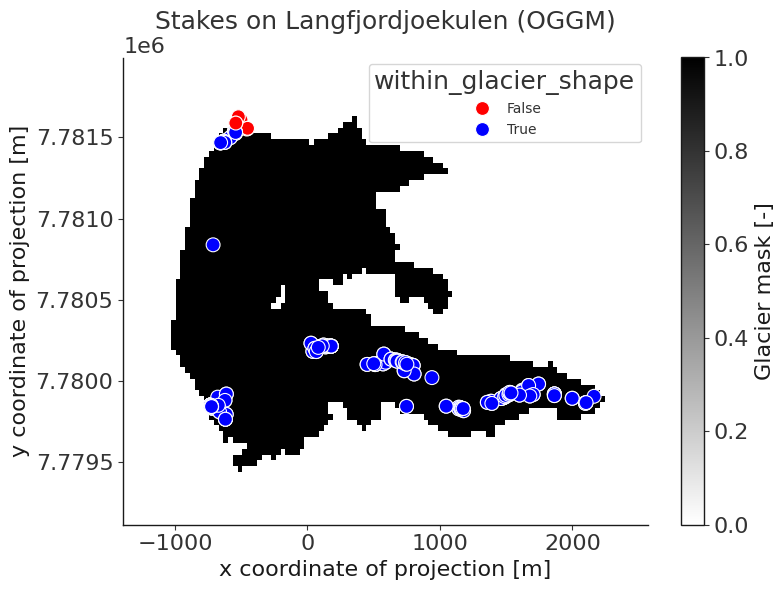

In [12]:
# Example:
glacierName = 'Langfjordjoekulen'
# stakes
df_stakes_topo_1 = df_stakes_topo.copy()
df_stakes_topo_1 = df_stakes_topo_1[(df_stakes_topo_1['GLACIER'] == glacierName)]
RGIId = df_stakes_topo_1['RGIId'].unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/OGGM/xr_grids/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes_topo_1["POINT_LON"].values, df_stakes_topo_1["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes_topo_1['x'] = x_stake
df_stakes_topo_1['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes_topo_1,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

###### Only keep glaciers within RGIId shape and drop rows with NaN values anywhere

In [13]:
# restrict to within glacier shape
df_stakes_topo = df_stakes_topo[df_stakes_topo['within_glacier_shape'] == True]
df_stakes_topo = df_stakes_topo.drop(columns=['within_glacier_shape'])

# Drop rows with NaN in consensus_ice_thickness
df_stakes_topo = df_stakes_topo.dropna(subset=['consensus_ice_thickness'])

print('Number of winter and annual samples:', len(df_stakes_topo))
print('Number of annual samples:',
      len(df_stakes_topo[df_stakes_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_stakes_topo[df_stakes_topo.PERIOD == 'winter']))

# Unique glaciers, sorted
glacier_list = sorted(df_stakes_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

# Display rows with NaN values in any column
display(df_stakes_topo[df_stakes_topo.isna().any(axis=1)])

Number of winter and annual samples: 6529
Number of annual samples: 3324
Number of winter samples: 3205
Number of glaciers: 32
Glaciers: ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blaaisen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Cainhavarre', 'Engabreen', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen', 'Hellstugubreen', 'Hoegtuvbreen', 'Juvfonne', 'Langfjordjoekulen', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen', 'Rundvassbreen', 'Storglombreen N', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Svelgjabreen', 'Trollbergdalsbreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness


In [14]:
display(df_stakes_topo.head(2))

# Create new POINT_ID column
df_stakes_topo['POINT_ID'] = (
    df_stakes_topo['GLACIER'] + '_' + 
    df_stakes_topo['YEAR'].astype(str) + '_' + 
    df_stakes_topo['PERIOD'].astype(str) + '_' +
    df_stakes_topo.index.astype(str)
)

display(df_stakes_topo.head(2))


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,36.073272,15.972541,425.458893,-3.314563,96.980293
1,70.12578,21.77630,439,20131107,20140924,-2.67,annual,RGI60-08.01258,2014,Langfjordjoekulen,33.570984,16.993369,434.652008,-2.934460,89.294670


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,POINT_ID
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,36.073272,15.972541,425.458893,-3.314563,96.980293,Langfjordjoekulen_2013_annual_0
1,70.12578,21.77630,439,20131107,20140924,-2.67,annual,RGI60-08.01258,2014,Langfjordjoekulen,33.570984,16.993369,434.652008,-2.934460,89.294670,Langfjordjoekulen_2014_annual_1


##### Remove stakes that are close to eachother

In [19]:
close_stakes_df = find_close_stakes(df_stakes_topo)

# Display summary by glacier, period
if not close_stakes_df.empty:
    # Group by glacier and period
    summary = close_stakes_df.groupby(['GLACIER', 'PERIOD']).size().unstack(fill_value=0)
    summary['TOTAL'] = summary.sum(axis=1)
    summary = summary.sort_values('TOTAL', ascending=False).reset_index()
    
    print("\nGlaciers with most close stake pairs:")
    display(summary.head(10))
    
    # Set pandas to display all rows - add this before displaying the dataframe
    pd.set_option('display.max_rows', None)

    # Display all close stake pairs sorted by distance
    print("\nAll close stake pairs (sorted by distance):")
    display(close_stakes_df.sort_values('DISTANCE_M'))

    # Reset back to default number of rows displayed after displaying
    pd.set_option('display.max_rows', pd.options.display.max_rows)

Processing glacier-year-periods:   0%|          | 0/853 [00:00<?, ?it/s]

Found 368 pairs of stakes that are 10m or closer

Glaciers with most close stake pairs:


PERIOD,GLACIER,annual,winter,TOTAL
0,Engabreen,75,77,152
1,Aalfotbreen,32,22,54
2,Hansebreen,27,20,47
3,Austdalsbreen,20,20,40
4,Nigardsbreen,13,7,20
5,Langfjordjoekulen,12,7,19
6,Rembesdalskaaka,6,5,11
7,Trollbergdalsbreen,4,4,8
8,Blomstoelskardsbreen,3,3,6
9,Storsteinsfjellbreen,3,1,4



All close stake pairs (sorted by distance):


,GLACIER,YEAR,PERIOD,POINT_ID_1,POINT_ID_2,LAT_1,LON_1,LAT_2,LON_2,POINT_BALANCE_1,POINT_BALANCE_2,DISTANCE_M
166,Engabreen,1971,annual,Engabreen_1971_annual_719,Engabreen_1971_annual_720,66.68408,13.76826,66.68408,13.76826,-6.90,-6.27,0.000000
168,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4585,66.68408,13.76826,66.68408,13.76826,-0.77,-0.87,0.000000
169,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4586,66.68408,13.76826,66.68408,13.76826,-0.77,-1.18,0.000000
170,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4606,66.68408,13.76826,66.68408,13.76826,-0.77,-1.75,0.000000
171,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4607,66.68408,13.76826,66.68408,13.76826,-0.77,-2.39,0.000000
172,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4608,66.68408,13.76826,66.68408,13.76826,-0.77,-1.58,0.000000
173,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4609,66.68408,13.76826,66.68408,13.76826,-0.77,-0.61,0.000000
174,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4610,66.68408,13.76826,66.68408,13.76826,-0.77,-1.30,0.000000
175,Engabreen,1971,winter,Engabreen_1971_winter_4583,Engabreen_1971_winter_4611,66.68408,13.76826,66.68408,13.76826,-0.77,-1.18,0.000000
160,Engabreen,1971,annual,Engabreen_1971_annual_716,Engabreen_1971_annual_720,66.68408,13.76826,66.68408,13.76826,-6.74,-6.27,0.000000


###### First merge stakes with identical lat/lon, then merge close stakes (within 10m of each other)

In [20]:
df_stakes_topo = merge_identical_stakes(df_stakes_topo, close_stakes_df)

Found 235 pairs of stakes with identical coordinates
Merged 113 identical stakes
Original dataframe size: 6529
After merging identical stakes: 6416
Kept point IDs: ['Aalfotbreen_1967_annual_1632', 'Aalfotbreen_1967_winter_5454', 'Aalfotbreen_1989_annual_1298', 'Aalfotbreen_1989_winter_5142', 'Aalfotbreen_1992_annual_1246', 'Aalfotbreen_1992_annual_1471', 'Aalfotbreen_1992_annual_1578', 'Aalfotbreen_1992_winter_5405', 'Aalfotbreen_1994_annual_1592', 'Aalfotbreen_1994_winter_5403', 'Aalfotbreen_2013_annual_1359', 'Aalfotbreen_2013_winter_5199', 'Austdalsbreen_2009_annual_3028', 'Austdalsbreen_2009_winter_6782', 'Austdalsbreen_2011_annual_3052', 'Austdalsbreen_2011_annual_3081', 'Austdalsbreen_2011_winter_6806', 'Austdalsbreen_2011_winter_6842', 'Austdalsbreen_2012_annual_3033', 'Austdalsbreen_2012_annual_3082', 'Austdalsbreen_2012_winter_6787', 'Austdalsbreen_2012_winter_6843', 'Austdalsbreen_2013_annual_3020', 'Austdalsbreen_2013_annual_3083', 'Austdalsbreen_2013_winter_6774', 'Austdals

In [21]:
close_stakes_df = close_stakes_df[close_stakes_df['DISTANCE_M'] > 0]

df_stakes_topo_dropped = merge_close_stakes(df_stakes_topo, close_stakes_df, distance_threshold=10)

print(f"Original dataframe size: {len(df_stakes_topo)}")
print(f"After merging close stakes: {len(df_stakes_topo_dropped)}")

Merging stakes within 10m: 0it [00:00, ?it/s]

Merged 119 pairs of close stakes
Original dataframe size: 6416
After merging close stakes: 6297


In [ ]:
# Save df to folder
df_stakes_topo_dropped.to_csv(path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv', index=False)
